In [42]:
import os
import sys
sys.path.insert(0, "../models/multimodal")
sys.path.insert(0, "../models/caption_generator")

In [43]:
from pathlib import Path
from recommender import ImageRecommender
bin_root = Path("../models/multimodal/bin")

recommender = ImageRecommender(bin_root/"model_22.pth", bin_root/"embedding.pkl")

['parking meter']


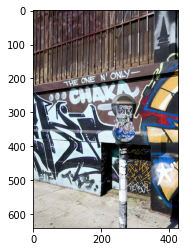

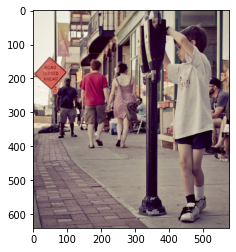

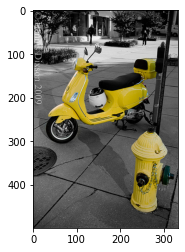

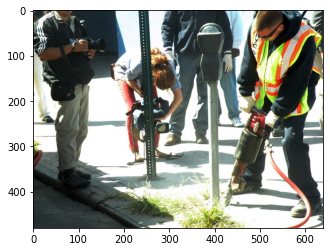

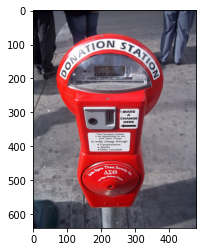

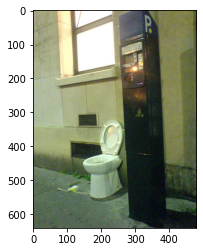

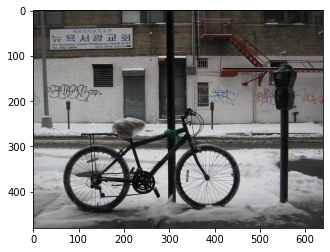

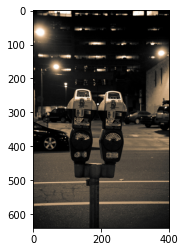

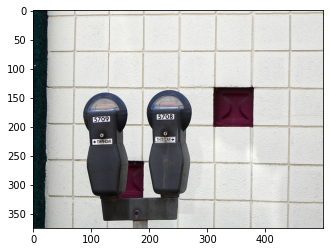

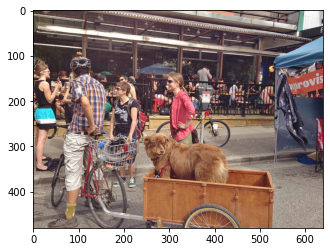

In [44]:
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

root = Path("../data")
images = list()
tensor_images = list()
multi_transform = transforms.Compose([
    transforms.Resize((224,244)),
    transforms.ToTensor()])

with open(root/"levels.pkl", "rb") as f:
    levels = pickle.load(f)
    level = levels[10][1][30]
    imgs = level["imgs"]
    selected_set = level["selected_set"]
    print(selected_set)
    imgs = [root/"mscoco/val2014"/img["file_name"] for img in imgs]
    for img in imgs:
        img = Image.open(img).convert("RGB")
        plt.imshow(img)
        plt.show()
        images.append(img)
        tensor_images.append(multi_transform(img))

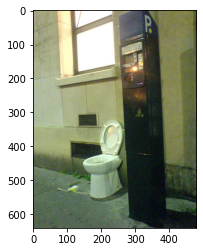

In [25]:
idx = recommender.search_image("A toilet next to a parking meter", tensor_images)
plt.imshow(images[idx])

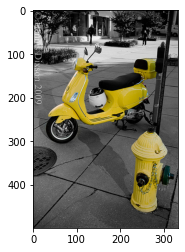

In [26]:
idx = recommender.search_image("A motorcycle next to a fire hydrant", tensor_images)
plt.imshow(images[idx])

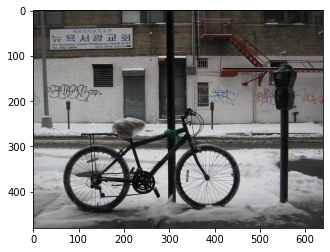

In [27]:
idx = recommender.search_image("A bicycle standing on a road", tensor_images)
plt.imshow(images[idx])

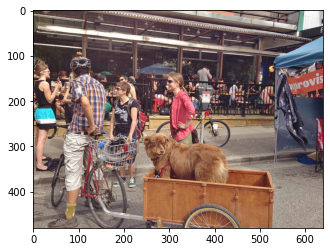

In [28]:
idx = recommender.search_image("dog", tensor_images)
plt.imshow(images[idx])

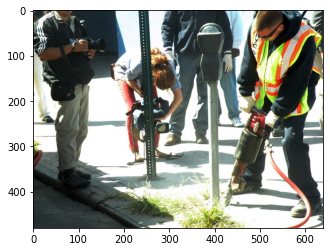

In [29]:
idx = recommender.search_image("dwarves mining for treasure", tensor_images)
plt.imshow(images[idx])

In [30]:
from pl_model import CaptionGenerator
from utilities import get_dataset

caption_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])

dataset, pad_idx = get_dataset(
    '../data/flickr8k/images',
    '../data/flickr8k/training_captions.csv',
    caption_transform)

model = CaptionGenerator.load_from_checkpoint(checkpoint_path="../epoch=998.ckpt", pad_idx=pad_idx)
model.eval()

CaptionGenerator(
  (cnntornn): CNNtoRNN(
    (encoderCNN): EncoderCNN(
      (inception): Inception3(
        (Conv2d_1a_3x3): BasicConv2d(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (Conv2d_2a_3x3): BasicConv2d(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (Conv2d_2b_3x3): BasicConv2d(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (Conv2d_3b_1x1): BasicConv2d(
          (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=Tr

In [37]:
caption_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [45]:
captions = list()
for img in images:
    caption = model.caption_image(caption_transform(img).unsqueeze(0), dataset.vocab)
    caption = " ".join(caption[1:-1])
    captions.append(caption)

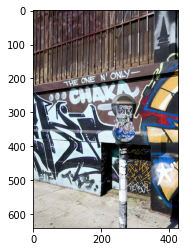

a man in a red shirt is standing in a stadium holding a religious sign that says " those in green shirts <UNK> " .


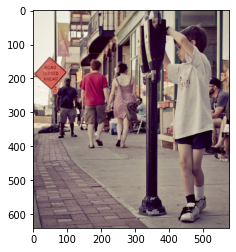

a man in a white shirt and black pants is skating down a sidewalk .


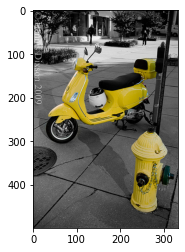

a man is riding a motorcycle on a track .


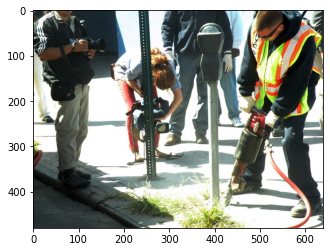

a man in a red jacket is standing in a stadium holding a sign that says " those <UNK> " .


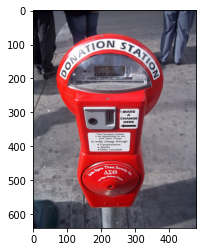

a man in a red jacket is standing in front of a huge brick building .


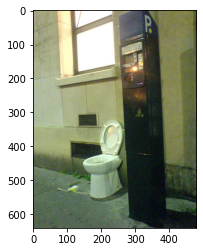

a man sits on a bench with his arm around a corner .


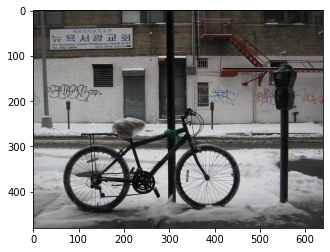

a man on a bike is jumping over a sign that says " free dinner " .


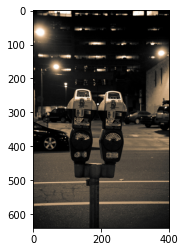

a man in a black jacket and hat talks to a phone .


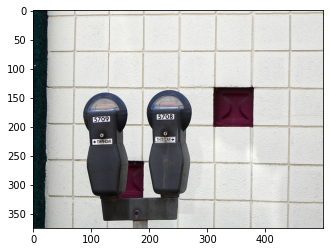

a man in a red shirt is standing in a stadium holding a guitar .


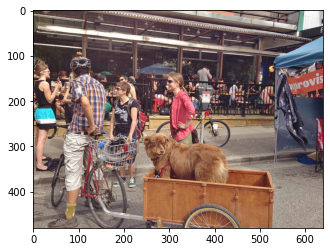

a man in a red jacket is standing next to a large truck with a tree .


In [46]:
for caption, image in zip(captions, images):
    plt.imshow(image)
    plt.show()
    print(caption)

In [47]:
num_found = 0
for i, caption in enumerate(captions):
    idx = recommender.search_image(caption, tensor_images)
    if idx == i:
        num_found += 1
print("Accuracy:", num_found / len(captions))

Accuracy: 0.3


In [48]:
for n in range(9, 10):
    for c in range(4, 6):
        acc = 0
        for j in range(50):
            print('Evaluating: ', n, c, j)
            level = levels[n][c][j]

            if level['selected_set'] == 0:
                continue
            
            imgs = level["imgs"]
            selected_set = level["selected_set"]
            imgs = [root/"mscoco/val2014"/img["file_name"] for img in imgs]
            tensor_images = list()
            captions = list()
            for img in imgs:
                data = Image.open(img).convert("RGB")
                tensor_images.append(multi_transform(data))
                caption = model.caption_image(caption_transform(data).unsqueeze(0), dataset.vocab)
                caption = " ".join(caption[1:-1])
                captions.append(caption)
                                              
            num_found = 0
            for i, caption in enumerate(captions):
                idx = recommender.search_image(caption, tensor_images)
                if idx == i:
                    num_found += 1
            acc += num_found / len(captions)
            print("Accuracy:", num_found / len(captions))
        print("outer acc:", acc / 50)

Evaluating:  9 4 0
Accuracy: 0.2222222222222222
Evaluating:  9 4 1
Accuracy: 0.1111111111111111
Evaluating:  9 4 2
Accuracy: 0.2222222222222222
Evaluating:  9 4 3
Accuracy: 0.1111111111111111
Evaluating:  9 4 4
Accuracy: 0.3333333333333333
Evaluating:  9 4 5


KeyboardInterrupt: 